## Multi-Class Image Classification

We've just been through a bunch of the following steps with a binary classification problem. Now, we're goining o step thing up a notch with 10 classes of food.

1. Become one with the data
2. Preprocess the data (get it ready for a model)
3. Create a model (start with a baseline)
4. Fit the model (overfit it to make sure it works)
5. Evaluate the model
6. Adjust different hyperparameters and improve the model (try to beat baseline/reduce overfitting)
7. Reduce until satisfied

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
import os

In [2]:
## 1. Import the data

#Wlak through 10 classes of food image data
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_all_data
There are 10 directories and 0 images in 10_food_classes_all_data/test
There are 0 directories and 250 images in 10_food_classes_all_data/test/ice_cream
There are 0 directories and 250 images in 10_food_classes_all_data/test/chicken_curry
There are 0 directories and 250 images in 10_food_classes_all_data/test/steak
There are 0 directories and 250 images in 10_food_classes_all_data/test/sushi
There are 0 directories and 250 images in 10_food_classes_all_data/test/chicken_wings
There are 0 directories and 250 images in 10_food_classes_all_data/test/grilled_salmon
There are 0 directories and 250 images in 10_food_classes_all_data/test/hamburger
There are 0 directories and 250 images in 10_food_classes_all_data/test/pizza
There are 0 directories and 250 images in 10_food_classes_all_data/test/ramen
There are 0 directories and 250 images in 10_food_classes_all_data/test/fried_rice
There are 10 directories and 0 images in 10_fo

In [3]:
# Set up train and test directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [4]:
# Let's get the class names
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [5]:
# Let's visualize our images

def view_random_image(target_dir, target_class):
    # Set the target directory
    target_floder = target_dir + target_class

    # Get a random image path
    random_image = random.sample(os.listdir(target_floder), 1)

    # Read in the image and plot it
    img = mpimg.imread(target_floder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");

    print(f"Image shape: {img.shape}")

    return img


Image shape: (512, 512, 3)


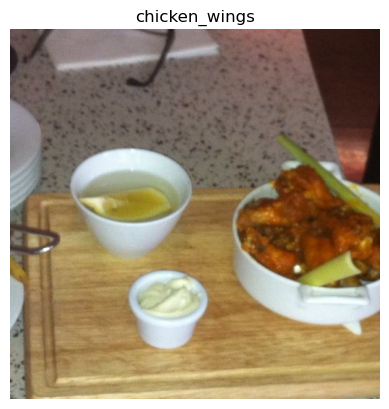

In [6]:
# Visualize
img = view_random_image(train_dir, random.choice(class_names))

### 2.  Preprocess the data (prepare it for a model) 🌏